# 数据加载

In [1]:
import scipy.io as scio
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

E1 = scio.loadmat('DB2/S1_E1_A1.mat')
E2 = scio.loadmat('DB2/S1_E2_A1.mat')
E3 = scio.loadmat('DB2/S1_E3_A1.mat')


E1_emg = E1['emg']
E2_emg = E2['emg']
E3_emg = E3['emg']

E1_label = E1['restimulus']
E2_label = E2['restimulus']
E3_label = E3['restimulus']

E1_acc = E1['acc']
E2_acc = E2['acc']
E3_acc = E3['acc']

emg = np.vstack((E1_emg,E2_emg,E3_emg))
label = np.vstack((E1_label,E2_label,E3_label))
acc = np.vstack((E1_acc,E2_acc,E3_acc))
label = label-1

emg = emg * 20000

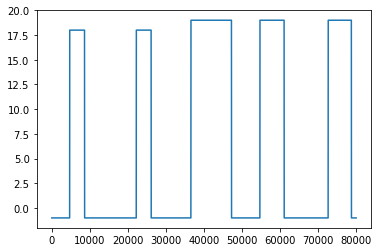

In [3]:
plt.plot(label[2000000:2080000])

# 加载模型

In [5]:
from tensorflow import keras

model = keras.models.load_model('model/CNN1d_fused_200_96_model.h5')


# 小波分解

In [6]:
import pywt
import pywt.data

mode = pywt.Modes.smooth

def plot_signal_decomp(data, w, title):
    w = pywt.Wavelet(w) #选取小波函数
    a = data
    ca = [] #近似分量
    cd = [] #细节分量
    for i in range(5):
        (a, d) = pywt.dwt(a, w, mode) #进行5阶离散小波变换
        ca.append(a)
        cd.append(d)

    rec_a = []
    rec_d = []

    for i, coeff in enumerate(ca):
        coeff_list = [coeff, None] + [None] * i
        rec_a.append(pywt.waverec(coeff_list, w))#重构

    for i, coeff in enumerate(cd):
        coeff_list = [None, coeff] + [None] * i
        rec_d.append(pywt.waverec(coeff_list, w))

    return rec_a


# 实时判断

6.51775050163269
26.879014015197754
0.5675
0.0


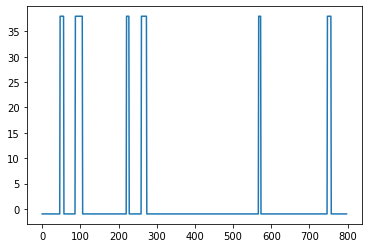

In [11]:
import time
index = 2000000
slide = 100
window = 200
res = []
lst = time.time()
time1 = 0
time2 = 0
pre_label=[]
state = -1
count = np.zeros(50)
move_all = 0
cnt_all = 0
cnt_move = 0

while index + window < 2080000:
    subEmg = emg[index: index + window, :]
    subAcc = acc[index:index + window, :]
    subImage = []
    for k in range(0, 36):
        subImage.append(subAcc[:, k])
    for k in range(0, 12):
         output = plot_signal_decomp(subEmg[:, k], 'sym5', "DWT")
         for obj in output:
            subImage.append(obj.tolist());
    
    subImage = list(map(list, zip(*subImage)))
    data = np.array(subImage)
    data = np.expand_dims(data, axis=0)
    data = np.expand_dims(data, axis=2)
    time1 = time1 + time.time() - lst
    lst = time.time()

    pre = model.predict(data, batch_size=1)
    mx = np.max(pre, axis = 1)
    ans = np.argmax(pre, axis = 1)
    time2 = time2 + time.time() - lst
    lst = time.time()

    if len(pre_label) == 20:
        count[pre_label[0] + 1] = count[pre_label[0] + 1] - 1
        del(pre_label[0])
    if mx < 0.9:
        pre_label.append(-1)
        count[0] = count[0] + 1
    else:
        pre_label.append(ans)
        count[ans + 1] = count[ans + 1] + 1

    if state == -1:
        mx_count = np.max(count)
        mx_label = np.argmax(count)
        if mx_count > 17 and mx_label > 0:
            state = mx_label - 1
    else:
        if count[0] > 10:
            state = -1
        mx_count = np.max(count)
        if mx_count <= 15:
            state = -1

    res.append(state)
    if label[index] > 0:
        move_all = move_all + 1
        if label[index] == state:
            cnt_move = cnt_move + 1

    if label[index] == state:
        cnt_all = cnt_all + 1
    index = index + slide

print(time1)
print(time2)
print(cnt_all / 800)
print(cnt_move/move_all)
plt.plot(res)

[[1.3918192e-10 1.7209216e-13 5.6274017e-09 6.2618462e-08 7.9602716e-16
  1.0301785e-12 2.7398164e-20 6.8885470e-22 1.1125785e-12 5.2766097e-10
  1.6453893e-04 1.9523666e-06 1.3929605e-11 5.2739654e-13 2.4014379e-10
  3.4358657e-03 7.0593338e-03 7.9181275e-09 7.7114115e-10 2.2965457e-08
  2.3819491e-07 2.1255566e-06 7.2740499e-05 1.0815102e-06 7.1294664e-05
  7.9859950e-05 7.3538726e-04 6.5717659e-06 1.3046042e-09 1.7738776e-09
  1.1789152e-09 9.7313446e-10 1.5550882e-09 1.8092541e-09 4.4898456e-04
  3.7510939e-14 1.0787015e-09 1.5249015e-01 7.7827275e-01 9.9918416e-06
  9.7380055e-11 1.6726592e-11 1.8013128e-10 1.5564998e-10 4.4819787e-02
  6.5768481e-04 1.7531319e-08 1.5452401e-06 1.1668036e-02]]
[[9.80723947e-02 2.81005939e-08 2.33448736e-06 2.37637743e-10
  1.33147723e-17 7.51850280e-08 2.73856933e-15 1.63702951e-21
  6.23339063e-19 1.16804054e-15 1.81078633e-06 1.22975853e-05
  1.90734884e-12 1.23137008e-14 5.86157733e-10 6.27381727e-03
  1.24971904e-02 3.01468017e-11 1.56544428e-

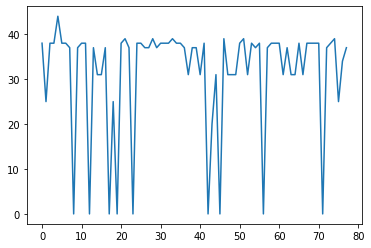

In [15]:
import time
index = 3000000
slide = 100
window = 200
res = []
maxx = []
lst = time.time()
time1 = 0
time2 = 0
pre_label=[]
state = -1
count = np.zeros(50)
move_all = 0
cnt_all = 0
cnt_move = 0

while index + window < 3080000:
    subEmg = emg[index: index + window, :]
    subAcc = acc[index:index + window, :]
    subImage = []
    for k in range(0, 36):
        subImage.append(subAcc[:, k])
    for k in range(0, 12):
         output = plot_signal_decomp(subEmg[:, k], 'sym5', "DWT")
         for obj in output:
            subImage.append(obj.tolist());
    
    subImage = list(map(list, zip(*subImage)))
    data = np.array(subImage)
    data = np.expand_dims(data, axis=0)
    data = np.expand_dims(data, axis=2)
    time1 = time1 + time.time() - lst
    lst = time.time()

    pre = model.predict(data, batch_size=1)
    print(pre)
    mx = np.max(pre, axis = 1)
    ans = np.argmax(pre, axis = 1)
    # time2 = time2 + time.time() - lst
    lst = time.time()

    res.append(ans)
    maxx.append(mx)
    index = index + slide

print(res)
plt.plot(res)